<a href="https://colab.research.google.com/github/anna-dang/mod05-capstone/blob/main/NLP_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hotel Review Classifier (working title)

*Flatiron School Data Science Bootcamp*

Captsone Project - NLP Sentiment/Ratings Analysis

Anna D'Angela | [annaadangela@gmail.com](mailto:annaadangela@gmail.com)

[Return to GitHub repo](https://github.com/anna-dang/mod05-capstone) 


# EDA TODO
- upgrade plot design


In [1]:
# Auto - reload custom function library
%load_ext autoreload
%autoreload 2

In [51]:
# Standard libararies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import warnings
warnings.filterwarnings('ignore')

# Mapping libraries
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

# NLP libraries
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')

# Modeling libraries
from sklearn import svm
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer, label_binarize
from sklearn.utils import class_weight
from scipy import interp

# My custome functions
from capstone_functions import NLP_functions as NLP

# Random seed
seed = 619

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/annadangela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annadangela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import data and explore

In [4]:
# Import clean data
df_raw = pd.read_csv("./data/clean_scrape.csv")

# Check load
display(df_raw.head())
df_raw.info()

,Location,Hotel,Title,Review,Rating
0,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Great View,Easy check in and check out process using the ...,5
1,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Clean and Comfortable,We needed a last-minute place to stay in Denve...,5
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,We love Hyatt hotels and have had many great e...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,"I have never encountered such helpful, friendl...",5
4,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Our 'see downtown' hotel,"We love it here! Great service, they usually r...",5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22217 entries, 0 to 22216
Data columns (total 5 columns):
Location    22217 non-null object
Hotel       22217 non-null object
Title       22217 non-null object
Review      22217 non-null object
Rating      22217 non-null int64
dtypes: int64(1), object(4)
memory usage: 868.0+ KB


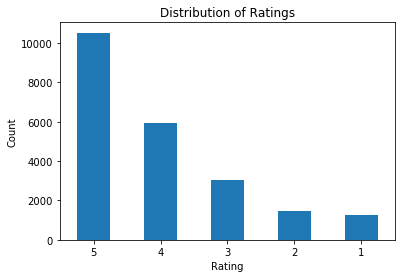

In [5]:
# Examine class distribution by count
df_raw['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

In [6]:
# Examine imbalance as percentage
percent = round(df_raw['Rating'].value_counts(1).to_frame(name='Percent %').rename_axis('Rating') * 100, 2)
percent

,Percent %
Rating,
5,47.36
4,26.66
3,13.62
2,6.69
1,5.67


There is a significant imbalance in classes. First I will randomly undersample the most major class, 5 by equalizing the amount with the second highest class, 4. This is to reduce the dimensions for the model by growing the total corpus largely positive.

In [7]:
tot_5 = df_raw[df_raw['Rating'] == 5].count()[0] 
tot_4 = df_raw[df_raw['Rating'] == 4].count()[0] 
drop_n = tot_5 - tot_4
drop_n

4600

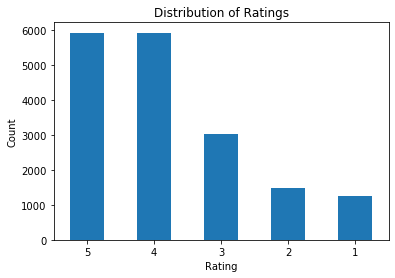

In [8]:
test = df_raw.drop(df_raw[df_raw['Rating'].eq(5)].sample(drop_n, random_state=seed).index)

# Examine class distribution by randomly reducing the most major class
test['Rating'].value_counts().plot(kind='bar', rot = 0);
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel("Count")
plt.show()

Remaining class imbalance is less sever, I will address this by using class weights when modeling.

### Collection distribution

In [20]:
# Examine collection distribution by location
avg_df = df_raw.groupby(by = 'Hotel')[['Rating']].agg(['count', 'mean'])

coords = pd.read_csv("./data/coordinates.csv", names = ['Hotel', 'Lat', 'Long'])

map_df = pd.merge(avg_df, coords, on = 'Hotel')
map_df.columns = ['Hotel', 'Rating_count', 'Rating_mean', 'Lat', 'Long']
map_df

,Hotel,Rating_count,Rating_mean,Lat,Long
0,Baymont by Wyndham Denver International Airport,2094,3.949379,39.820740,-104.770119
1,Best Western Plus Denver International Airport...,1000,3.633000,39.824161,-104.770178
2,Clarion Hotel Denver Central,920,3.372826,39.783300,-104.990895
3,DoubleTree by Hilton Hotel Denver,2000,3.859500,39.763101,-104.904370
4,Embassy Suites by Hilton Denver International ...,1000,3.996000,39.824143,-104.775354
5,Grand Hyatt Denver Downtown,1000,4.488000,39.745762,-104.988802
6,Hilton Denver City Center,1000,4.101000,39.747159,-104.990145
7,Hyatt Place Denver/Cherry Creek,995,4.156784,39.695828,-104.938547
8,Hyatt Regency Denver At Colorado Convention Ce...,2000,4.460000,39.744213,-104.993667
9,La Quinta Inn & Suites by Wyndham Denver Airpo...,1000,3.803000,39.820897,-104.773078


In [33]:
# View hotels on map
px.set_mapbox_access_token(open("./driver/mapbox_token").read())

fig = px.scatter_mapbox(map_df,
                        title="Data Source Map - Denver Metro Area Hotels",
                        hover_name='Hotel',
                        lat='Lat',
                        lon='Long',
                        color='Rating_mean',
                        color_continuous_scale=px.colors.sequential.Tealgrn,
                        size='Rating_count',
                        size_max=15,
                        zoom=10,
                        height=500
                       )
fig.update_layout(title_font_family="Arial, bold",
                    title_font_color="black",
                    mapbox={"style": "stamen-toner"},
                    margin={"l": 0, "r": 0, "b": 0, "t": 80}
                    )
    
fig.show()

### Format for processing/modeling

In [9]:
# combine 'Title' and 'Review' into one chunk of text (seperate with a space)
test['Review'] = test['Title'] + ' ' + test['Review']
test.head()

,Location,Hotel,Title,Review,Rating
2,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Excellent Staff & Service,Excellent Staff & Service We love Hyatt hotels...,5
3,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Trip to Denver - a Hallmark Christmas,Trip to Denver - a Hallmark Christmas I have n...,5
6,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Experience,Experience Everything is good except there's n...,3
8,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Horrible,Horrible I was not impressed by the figures on...,1
9,"Denver, CO",Hyatt Regency Denver At Colorado Convention Ce...,Pretty Decent beware parking,Pretty Decent beware parking Rented mountain v...,3


In [10]:
# Drop columns uneeded for this analysis, save as working df for modeling
df = test.drop(columns = ['Location', 'Hotel', 'Title'])
df.head()

,Review,Rating
2,Excellent Staff & Service We love Hyatt hotels...,5
3,Trip to Denver - a Hallmark Christmas I have n...,5
6,Experience Everything is good except there's n...,3
8,Horrible I was not impressed by the figures on...,1
9,Pretty Decent beware parking Rented mountain v...,3


### Train / Test Split

**Split the sample data into 2 groups**: train and test, where train is further split into train and validation set k times using k-fold cross validation, and test is used to assess final model fitness.

# TODO
- working with 'test' df, manually equalized class 4 and 5; try with full data?
- word cloud fontt??

In [13]:
# Split BEFORE processsing to avoid leaking
X = df['Review']
y = df['Rating']

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=seed)

X_train.shape, X_test.shape

((14093,), (3524,))

In [14]:
# Class imbalance
y_train.value_counts(1) * 100

4    33.704676
5    33.640815
3    16.909104
2     8.578727
1     7.166678
Name: Rating, dtype: float64

In [47]:
# Set training weights to balance classes
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(y_train), 
                                                  y = y_train)
class_weights

array([2.79069307, 2.33134822, 1.1827948 , 0.59338947, 0.59451592])

### Natural Language Processing (NLP) / Corpus EDA
Transform unstructured data to a matrix of numbers. Fits to entire training data 'X_train' to build entire corpus.

#### Feature Engineering for Text Data
- Do we remove stop words or not?
- Do we stem or lemmatize our text data, or leave the words as is?
- Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
- Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
- Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
- What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

Start at baseline model, then adjust and see results.

# NLP TODO

- visuals: freq dist plot each class

- process function

- custom stop words/punct listt

- DROP common words: hotel, room, Denver..... non-signally common occuring to give model most meaningful pool



#### Build Text Pre-Processor

TODO cleaning - remove punctuation, captialization, regex for conjunctions

In [ ]:
corpus = ','.join(df['Review'])

In [57]:
# TODO regex tokenize: count words with apostrophes as a single word
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

In [69]:
from spacy.lang.en import English
nlp = English()
tokenizer_s = nlp.Defaults.create_tokenizer(nlp)
tokens_s = tokenizer_s(corpus.lower())
tokens_s[:30]

excellent staff & service we love hyatt hotels and have had many great experiences with their brand & properties.  we find the staff at this property to be

In [16]:
# tokenize, remove capitals


tokens = word_tokenize(corpus.lower())

print(len(tokens))
tokens[:30]

2111954


['excellent',
 'staff',
 '&',
 'service',
 'we',
 'love',
 'hyatt',
 'hotels',
 'and',
 'have',
 'had',
 'many',
 'great',
 'experiences',
 'with',
 'their',
 'brand',
 '&',
 'properties',
 '.',
 'we',
 'find',
 'the',
 'staff',
 'at',
 'this',
 'property',
 'to',
 'be',
 'particularly']

In [17]:
# remove stops words, reduce dimensionality
stopword_list = stopwords.words('english')
stopword_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [18]:
# punctuation
stopword_list.extend(string.punctuation)
stopword_list += ["''", '""', '...', '``']
stopword_list[-10:]

['_', '`', '{', '|', '}', '~', "''", '""', '...', '``']

In [19]:
len(stopword_list)

215

In [ ]:
# TODO remove numbers?
output = ''.join(c for c in text if not c.isdigit())

In [ ]:
# spell check?
from autocorrect import spell
text = "This is a wrld of hope"
spells = [spell(w) for w in (nltk.word_tokenize(text))]
print (spells)

In [ ]:
# remove non-english words/char??
# remove non-ascii via regex
data = re.sub("([^\x00-\x7F])+"," ",data)

# remove accents
text = unidecode.unidecode(text)

In [ ]:
# EXPLORE THIS, likely not necessary 
# stem or lemm to reduce words to base

# lemmatizer = WordNetLemmatizer()

# print(lemmatizer.lemmatize('feet')) # foot

In [20]:
# remove
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopword_list]
len(stopped_tokens)

987269

In [21]:
# dropped stops and puncts
len(tokens) - len(stopped_tokens)

1124685

# TODO process function

In [ ]:
def process_review(pattern=None, stopwords=None):
    
    

#### Frequency Distribution

In [36]:
freq = nltk.FreqDist(stopped_tokens)
freq.most_common(20)

[('hotel', 24039),
 ('room', 18939),
 ('great', 11234),
 ('stay', 11085),
 ('staff', 9490),
 ('nice', 7757),
 ('good', 7641),
 ('denver', 7275),
 ("n't", 7264),
 ('would', 7057),
 ('clean', 6759),
 ('rooms', 6409),
 ('location', 6208),
 ('breakfast', 5821),
 ('service', 5799),
 ('airport', 5617),
 ('one', 5589),
 ('stayed', 4705),
 ('night', 4686),
 ('desk', 4673)]

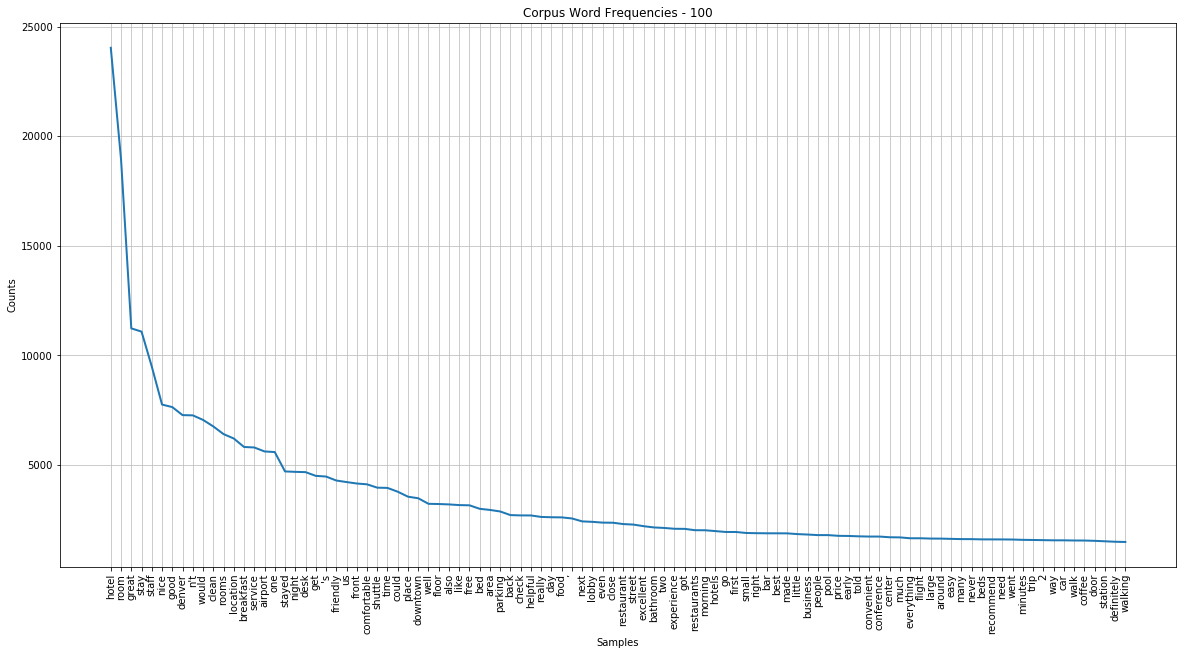

In [40]:
plt.figure(figsize=(20,10))
plt.title("Corpus Word Frequencies - 100")
freq.plot(100);

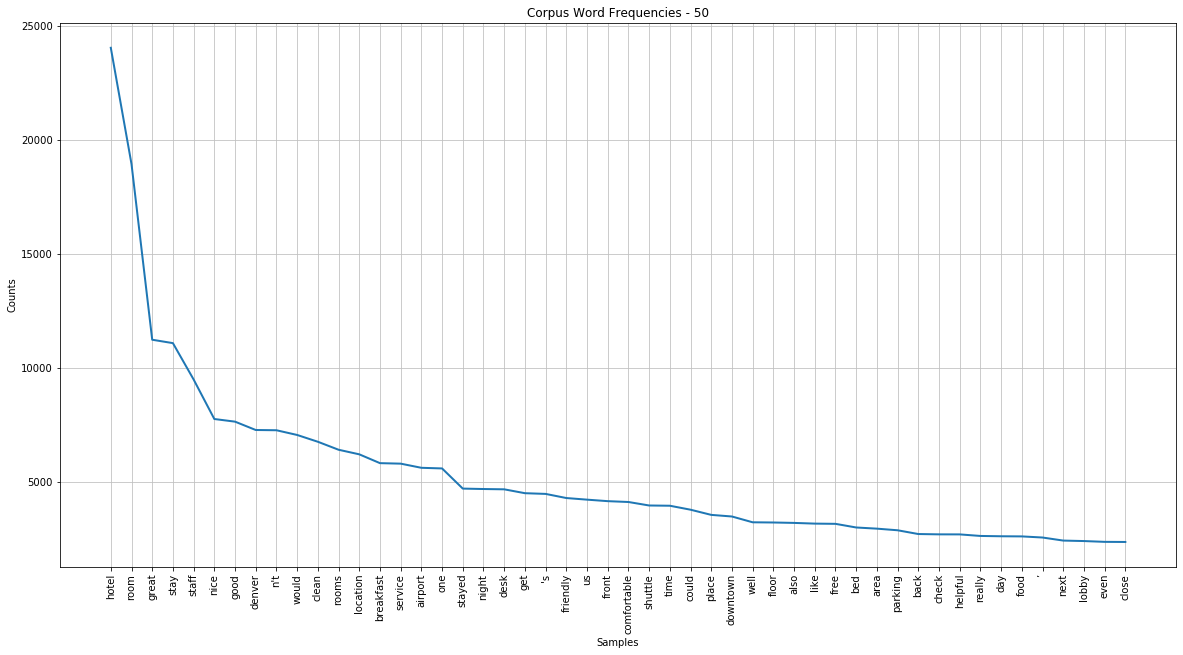

In [41]:
plt.figure(figsize=(20,10))
plt.title("Corpus Word Frequencies - 50")
freq.plot(50);

In [53]:
# PLOT FOR EACH CLASS!

# need to clean and get tokens for each class seperately

# then plot

def plot_word_frequencies(df, n=10, pattern=None, stopwords=None):
    
    fig, axes = plt.subplots(3, 2, figsize=(25, 30))
    fig.tight_layout(pad=0.2, w_pad=0.5, h_pad=1.2)

    for rating, ax in zip(list(range(6, 0, -1)), axes.flatten()):

        if 1 <= rating - 1 <= 5:
            reviews = df.loc[df['Rating'] == rating]['Review']

            review_tokens = list(map(process_review(pattern=None, stopwords=None), reviews))

            freq_n = nltk.FreqDist(stopped_tokens).most_common(n)

            freq_x = [i[0] for i in freq_n]
            freq_y = [i[1] for i in freq_n]

            ax.bar(freq_x, freq_y)
            ax.set_title(f"Class {i-1}", size=25, fontweight='bold')

        else:
            ax.axis('off')

In [ ]:
plot_word_frequencies(df, n=10)

In [54]:
# Add most common words appearing in all classes to removed words, thus not strong signal
# TODO: pull out hotel vocab, location details, titles/names? make more generic?
# distilling the overall vocabulary of our bag-of-words down only to the words that really matter

common_words = ['hotel', 'room', 'stay', 'denver']

removed_words = stopword_list + common_words

#### Word Cloud

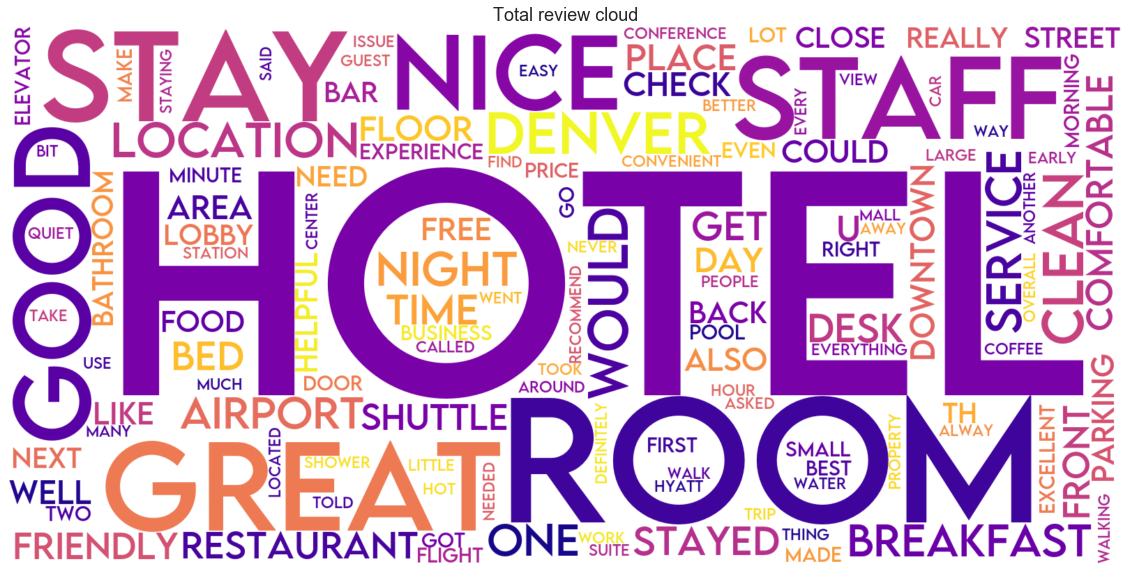

In [185]:
# Word cloud for full corpus
NLP.plot_cloud(NLP.make_cloud(df, rating=0, pattern=pattern, stopwords=stopword_list))
plt.title("Total review cloud");
plt.show()

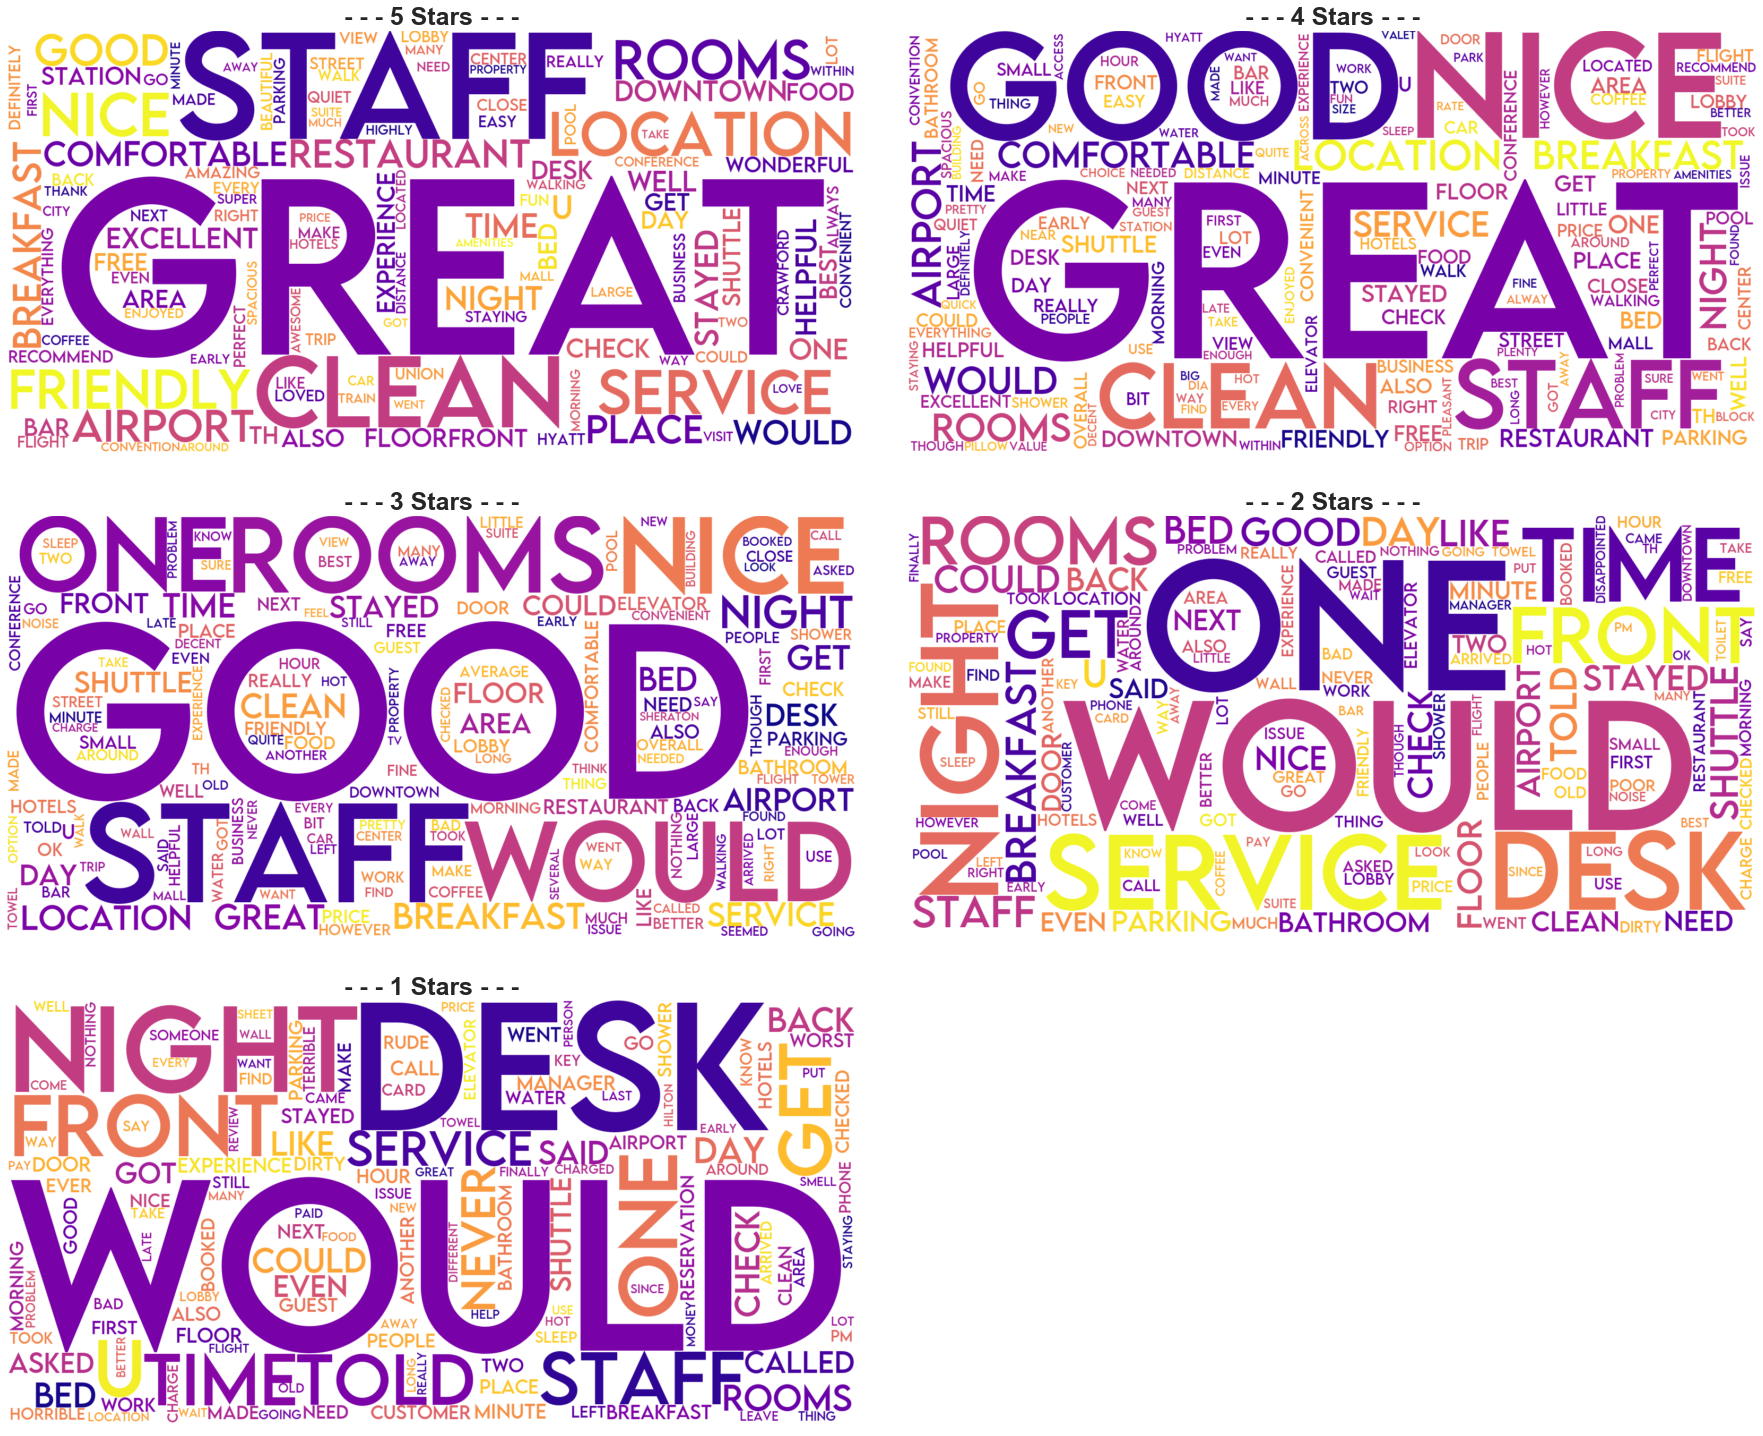

In [187]:
# Word cloud per class
NLP.plot_clouds_per_rating(df, pattern=pattern, stopwords=removed_words)

#### Vocabulary EDA

In [55]:
# N-grams, filter occruing greater than 5 times (frequency filter) keep only those that likely 'mean' something

# shorter alias for bigram method
bigram_measures = nltk.collocations.BigramAssocMeasures()

# create a finder
finder = nltk.collocations.BigramCollocationFinder.from_words(stopped_tokens)

# bigram scores
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored[:50]

[(('front', 'desk'), 0.003531965452171597),
 (('great', 'location'), 0.001647980438968508),
 (('staff', 'friendly'), 0.0012965058155376093),
 (('room', 'clean'), 0.0011607778629735158),
 (('downtown', 'denver'), 0.0011536875967947946),
 (('16th', 'street'), 0.001118236265901188),
 (('walking', 'distance'), 0.0009733922568215957),
 (('union', 'station'), 0.0009065411757079377),
 (('one', 'night'), 0.0008731156351511087),
 (('place', 'stay'), 0.0008680511593091649),
 (('nice', 'hotel'), 0.000834625618752336),
 (('hotel', 'great'), 0.0008123419250477833),
 (('would', 'stay'), 0.0008123419250477833),
 (('customer', 'service'), 0.0008042387637006733),
 (('street', 'mall'), 0.0007667616424702892),
 (('great', 'hotel'), 0.000763722956965123),
 (('convention', 'center'), 0.0007515682149444579),
 (('friendly', 'helpful'), 0.0007323232067450715),
 (('room', 'service'), 0.0007161168840508513),
 (('clean', 'comfortable'), 0.0006938331903462988),
 (('hotel', 'staff'), 0.0006756010773153011),
 (('de

In [77]:
# Pointwise Mutual Information (pmi) Score - mutual dependence between words

# create finder from corpus
pmi_finder = nltk.collocations.BigramCollocationFinder.from_words(stopped_tokens)

# apply frequency filter and set n
pmi_finder.apply_freq_filter(5)

# use finder to calculate PMI scores
pmi_scored = pmi_finder.score_ngrams(bigram_measures.pmi)
pmi_scored[:50]

[(('barnes', 'noble'), 17.608923757900495),
 (('darth', 'vader'), 17.60892375790049),
 (('ellie', 'caulkins'), 17.60892375790049),
 (('johnson', 'wales'), 17.60892375790049),
 (('los', 'angeles'), 17.386531336564047),
 (('marco', 'polo'), 16.971493837285202),
 (('crabtree', 'evelyn'), 16.871958163734288),
 (('bubba', 'gumps'), 16.734454639984353),
 (('corn', 'flakes'), 16.734454639984353),
 (('bubba', 'gump'), 16.73445463998435),
 (('c.o', 'bigelow'), 16.608923757900495),
 (('marge', 'simpson'), 16.27105411914411),
 (('clorox', 'wipes'), 16.19388625862165),
 (('katie', 'mullens'), 16.164138915227596),
 (('refried', 'beans'), 16.164138915227596),
 (('washers', 'dryers'), 16.12349693073025),
 (('caulkins', 'opera'), 16.023961257179337),
 (('smack', 'dab'), 16.023961257179337),
 (('i.m', 'pei'), 15.9995082134548),
 (('mt', 'evans'), 15.930851852787855),
 (('captive', 'audience'), 15.908484039759403),
 (('duct', 'tape'), 15.80156883584289),
 (('gon', 'na'), 15.801568835842886),
 (('bent', 

# Modeling - Review Classifier


# TODO
- choose metric       
- model iterations *dancing woman emoji*
- feature importance plot (function?), continue reduce dimens
- PICKLE GOOD MODELS!!!
- multi-class models/stacking?

- full 'text to predict' function (take in review, give score)

### !!!! evaluate function needs CROSS-VAL score and compare train details !!!!
  

### Baseline BOW
No pre-processing or text manipulations, raw reviews right into the chipper. Aim to improve upon this.

In [ ]:
# Set pipeline display
set_config(display='diagram')

In [179]:
bow_pipeline = Pipeline(steps=[("vectorizer", CountVectorizer(decode_error= 'ignore')),
                               ("clf", SGDClassifier(random_state=seed, 
                                                     shuffle=True, 
                                                     class_weight='balanced'))
                              ])

bow_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(decode_error='ignore')),
                ('clf',
                 SGDClassifier(class_weight='balanced', random_state=619))])

Classification Report: 

              precision    recall  f1-score   support

           1       0.52      0.60      0.56       249
           2       0.35      0.17      0.23       277
           3       0.49      0.37      0.42       643
           4       0.51      0.59      0.54      1173
           5       0.66      0.69      0.67      1182

    accuracy                           0.55      3524
   macro avg       0.50      0.49      0.49      3524
weighted avg       0.54      0.55      0.54      3524

Correct: 1942, 55.11%
Incorrect: 1582, 44.89%
ROC/AUC: 0.68


,actual_count,pred_count,diff,%_of_pred
class,,,,
1,249,290,41,8.23
2,277,139,-138,3.94
3,643,494,-149,14.02
4,1173,1359,186,38.56
5,1182,1242,60,35.24


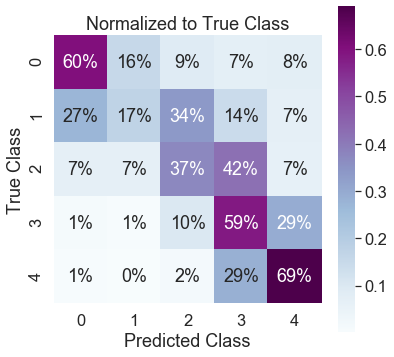

In [163]:
NLP.evaluate_model(bow_pipeline, X_test, y_test)

### Baseline Weighted BOW - TF-IDF
Scores words that appear heavily in articles from a given class, but rarely appear in articles from other classes.

In [175]:
weighted_bow_pipeline = Pipeline(steps=[("ttf-idf", TfidfVectorizer(decode_error= 'ignore')),
                                        ("clf", SGDClassifier(random_state=seed, 
                                                     shuffle=True, 
                                                     class_weight='balanced'))
                                      ])

weighted_bow_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ttf-idf', TfidfVectorizer(decode_error='ignore')),
                ('clf',
                 SGDClassifier(class_weight='balanced', random_state=619))])

Classification Report: 

              precision    recall  f1-score   support

           1       0.48      0.65      0.55       249
           2       0.31      0.40      0.35       277
           3       0.50      0.51      0.50       643
           4       0.61      0.41      0.49      1173
           5       0.68      0.80      0.73      1182

    accuracy                           0.57      3524
   macro avg       0.52      0.55      0.53      3524
weighted avg       0.58      0.57      0.57      3524

Correct: 2024, 57.43%
Incorrect: 1500, 42.57%
ROC/AUC: 0.721


,actual_count,pred_count,diff,%_actual,%_pred
class,,,,,
1,249,335,86,7.07,9.51
2,277,361,84,7.86,10.24
3,643,664,21,18.25,18.84
4,1173,778,-395,33.29,22.08
5,1182,1386,204,33.54,39.33


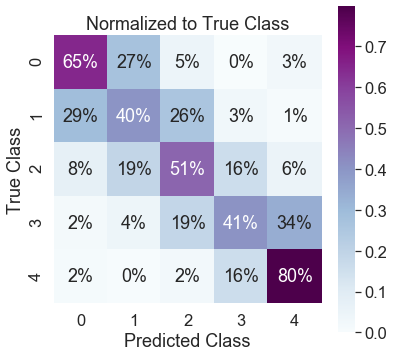

In [176]:
NLP.evaluate_model(weighted_bow_pipeline, X_test, y_test)

This alone jumped accuracy up by 2.3%! Let's continue on to process the text.

In [178]:
# FEATURE IMPORTANCES
# Get importances from model, set index as names from vectorizers
importance = pd.Series(weighted_bow_pipeline.named_steps['clf'].feature_importances_, 
                       index=weighted_bow_pipeline["ttf-idf"].get_feature_names())
importance.sort_values().tail(10).plot(kind='barh');

AttributeError: 'SGDClassifier' object has no attribute 'feature_importances_'

### Custom transformer pipeline

In [ ]:
NLP_pipeline = Pipeline([
        ('process text', make_transformer(process_review)),  # use custom pre-processing function per this corpus
        ('tf-idf vectorizer', TfidfVectorizer),
        ('classifier', classifier)
        ])

### Grid search to tune model

In [ ]:
# grid search... params 


# Display best params
display(grid.best_params_)

# Save best pipe (full pipe), best pipe in NOT the model, estimator is
best_pipe = grid.best_estimator_

# View best pipe
best_pipe

In [ ]:
# # Pickle model
# with open('./models/model.pickle', 'wb') as f:
#     pickle.dump(model, f)

# # Pickle vectorizer (to process text before using loaded model)
# # Different method (one line)
# pickle.dump(vectorizer_model, open('vectorizer_path', "wb"))
   
# # Load pickled model
# with open('./model/model.pickle', 'rb') as f:
#     model = pickle.load(f)
# type(model)

# # Load vectorizer (one line demo)
# vectorizer = pickle.load(open('vectorizer_path','rb'))

# # Using a loaded vectorizer(transform sample) and model (predict only, already trained)
# pred = model.predict(vectorizer.transform(["sample_text"]))[0]
# print ("predicted class:", pred)